In [ ]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as scp
import arviz as az
import pandas as pd
import xarray as xa
import seaborn as sns
import graphviz as gv

_Define macros_ ...
$$
\require{cancel}
\def\IndependentOf{\unicode{x2AEB}}
\def\NotIndependentOf{\cancel{\unicode{x2AEB}}}
$$       

In [ ]:
def scale_series(series):
    return (series - series.mean()) / series.std()

scale_series(pd.Series([1,2,3]))

0   -1.0
1    0.0
2    1.0
dtype: float64

In [ ]:
d = pd.read_csv('./data/WaffleDivorce.csv', sep=';')
d['A'] = scale_series(d.MedianAgeMarriage)
d['M'] = scale_series(d.Marriage)
d['D'] = scale_series(d.Divorce)
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,M,D
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,0.022644,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.549802,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.048974,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,1.655123,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.266989,-0.927058


In [ ]:
# Code 5.3

# Plot the relationship between median age at marriage and divorce rate
with pm.Model() as model5_3:
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bA * d.A)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d.D)
    trace5_3 = pm.sample()
    priorcheck5_3 = pm.sample_prior_predictive(samples=50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [D, a, bA, sigma]


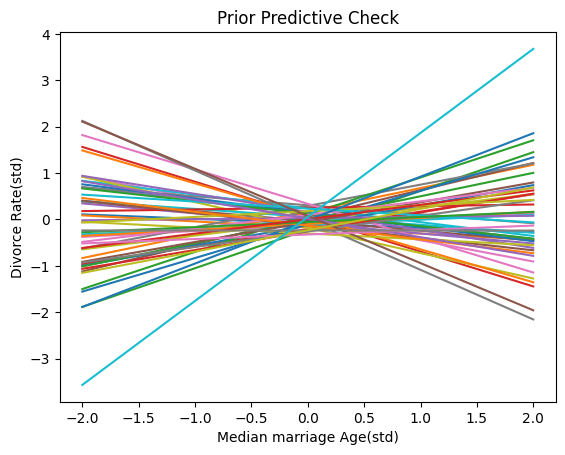

In [ ]:
# Prior predictive check
a = priorcheck5_3.prior.a[0].values
bA = priorcheck5_3.prior.bA[0].values
sigma = priorcheck5_3.prior.a[0].values

seq = np.linspace(-2, 2, 100)
mu = a + bA * np.expand_dims(seq,0).T


plt.plot(seq, mu)
plt.ylabel('Divorce Rate(std)')
plt.xlabel('Median marriage Age(std)')
plt.title('Prior Predictive Check')
plt.show()

Text(0.5, 1.0, 'Posterior Predictive Check')

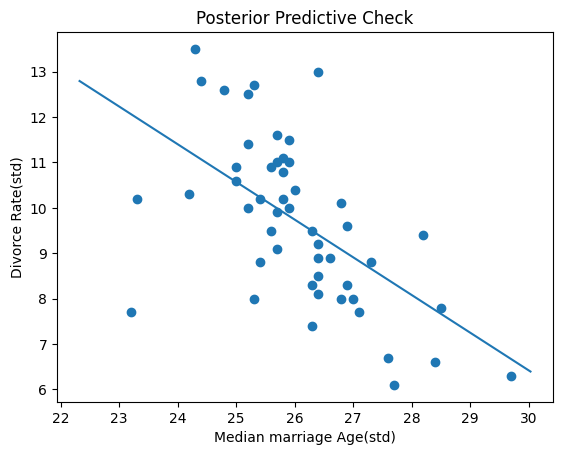

In [ ]:
# Posterior Predictive Check
A_seq = np.linspace(-3, 3.2, 30)
# just take the first chain for all of them
a = trace5_3.posterior.a[0].values
bA = trace5_3.posterior.bA[0].values
sigma = trace5_3.posterior.a[0].values

mu = a + bA * np.expand_dims(A_seq,0).T
mu_mean = mu.mean(axis=1)
mu_hdi = np.array([az.hdi(m) for m in mu])


plt.scatter(d.MedianAgeMarriage, d.Divorce)
plt.plot(d.MedianAgeMarriage.mean() + A_seq * d.MedianAgeMarriage.std(), d.Divorce.mean() + mu_mean * d.Divorce.std())
# plt.scatter(d.A, d.D)
# plt.plot(A_seq, mu_mean)
plt.ylabel('Divorce Rate(std)')
plt.xlabel('Median marriage Age(std)')
plt.title('Posterior Predictive Check')

## Spurious Association

A spurious association can happen either through mediation, or confounding.


In mediation, the real exposure affects the mediator, making it seem like the mediator is correlated with the outcome, but in reality, the mediator is caused by the exposure variable.

In confounding, the outcome variable and the exposure variable are both affected by a third, confounding variable, which makes it seem like there is an association between the exposure and the outcome.

rendering
rendering


Text(0.5, 1.0, 'Confounding')

<Figure size 1000x500 with 0 Axes>

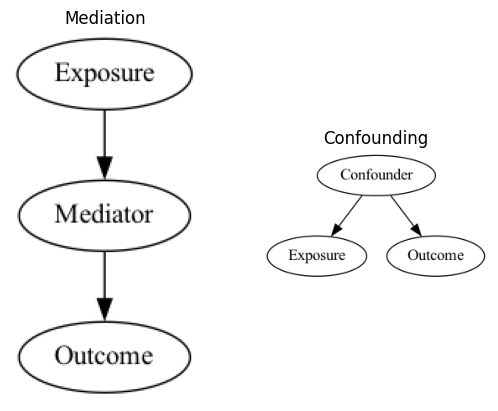

In [ ]:
import tempfile
def render_mediation_graph(filename):
    dot = gv.Digraph('Mediation', graph_attr={'splines': 'false'}, format='png')
    dot.node('E', 'Exposure')
    dot.node('M', 'Mediator')
    dot.node('O', 'Outcome')
    dot.edges(['EM', 'MO'])
    dot.render(format='png', outfile=filename)

def render_confounding_graph(filename):
    dot = gv.Digraph('Confounding', graph_attr={'splines': 'false'}, format='png')
    dot.node('E', 'Exposure')
    dot.node('C', 'Confounder')
    dot.node('O', 'Outcome')
    dot.edges(['CE', 'CO'])
    dot.render(format='png', outfile=filename)

if 'mediation_filename' not in locals():
    print('rendering')
    mediation_filename = tempfile.mktemp('.png')
    render_mediation_graph(mediation_filename)

if 'confounding_filename' not in locals():
    print('rendering')
    confounding_filename = tempfile.mktemp('.png')
    render_confounding_graph(confounding_filename)


img_A = plt.imread(mediation_filename)
img_B = plt.imread(confounding_filename)

plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1,2)
ax[0].axis('off')
ax[0].imshow(img_A)
ax[0].set_title('Mediation')
ax[1].axis('off')
ax[1].imshow(img_B)
ax[1].set_title('Confounding')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


Text(0.5, 1.0, 'Posterior Predictive Check')

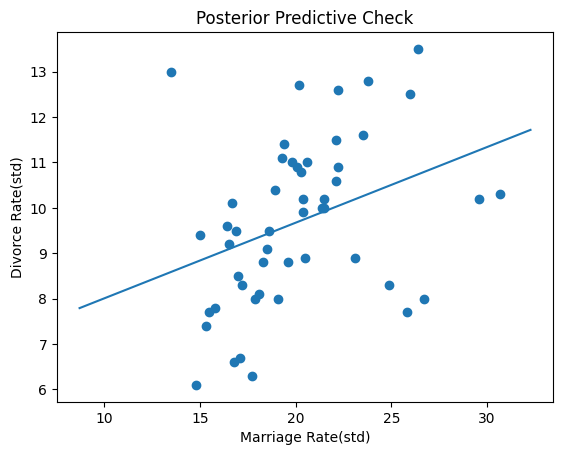

In [ ]:
# Codd 5.6
# Plot the relationship between marriage rate and divorce rate
with pm.Model() as model5_6:
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bA * d.M)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d.D)
    trace5_6 = pm.sample()

A_seq = np.linspace(-3, 3.2, 30)
# just take the first chain for all of them
a = trace5_6.posterior.a[0].values
bA = trace5_6.posterior.bA[0].values
sigma = trace5_6.posterior.a[0].values

mu = a + bA * np.expand_dims(A_seq,0).T
mu_mean = mu.mean(axis=1)
mu_hdi = np.array([az.hdi(m) for m in mu])


plt.scatter(d.Marriage, d.Divorce)
plt.plot(d.Marriage.mean() + A_seq * d.Marriage.std(), d.Divorce.mean() + mu_mean * d.Divorce.std())
# plt.scatter(d.A, d.D)
# plt.plot(A_seq, mu_mean)
plt.ylabel('Divorce Rate(std)')
plt.xlabel('Marriage Rate(std)')
plt.title('Posterior Predictive Check')

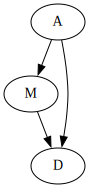

In [ ]:
dot = gv.Digraph('DAG for divorce rate example') #graph_attr={'splines': 'false'}
dot.node('A', 'A') # Median age at marriage
dot.node('M', 'M') # Marriage rate
dot.node('D', 'D') # Divorce rate

dot.edges(['AM', 'MD', 'AD'])
dot

What are the implications of the above DAG?
A affects D directly, since, say, people who get married younger have more time to get divorced, or that they are more immature when they are married. However, it also affects M directly, if people get married at a younger age, marriage rate may rise because there are more younger people in the population. M might affect D by making marriage more or less normative in the society.

However its also possible that M only affects D through M, like so:

First thing to consider is the _testable implications_ of each model. 
Any DAG may imply that some variables are independent from others under certain conditions. These are the model's testable implications, it's _conditional independencies_. Conditional independencies come in 2 forms.

First, they are statements of which variables should be associated with one another in the data. Second, they are statements of which variables become disassociated when we condition on some other set of variables.

Formally, $Y \IndependentOf X |Z$ means that Y is not associated with X, after conditioning on Z.

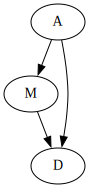

In [ ]:
dot = gv.Digraph('DAG for divorce rate example')
dot.node('A', 'A') # Median age at marriage
dot.node('M', 'M') # Marriage rate
dot.node('D', 'D') # Divorce rate

dot.edges(['AM', 'MD', 'AD'])
dot

For the first graph, where we have the edges `'AM', 'MD', 'AD'`, there is a causal arrow between every pair, so we have:


$$
D \NotIndependentOf A, D \NotIndependentOf M, A \NotIndependentOf M
$$

$\NotIndependentOf$ means "not independent of"

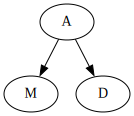

In [ ]:
dot = gv.Digraph('Second DAG for divorce rate example')
dot.node('A', 'A') # Median age at marriage
dot.node('M', 'M') # Marriage rate
dot.node('D', 'D') # Divorce rate

dot.edges(['AM', 'AD'])
dot

The second DAG that has `'AM', 'AD'` has the same conditional independencies as the above, with an extra:

$$
D \IndependentOf M|A
$$

Which means that D is independent of M, when we condition on A. That is, D is conditionally independent of M, and this is a testable implication of the model. To test this implication, we need a statistical model that conditions on A, so we can see whether that renders D independent of M. It can address the question:

_Is there any additional value in knowning a variable, once I already know all of the other predictor variables?_

In [ ]:
# 5.1.5
# When a model has multiple posteriors, more plotting needs to be done to help us understand the model.
# The author introduces 3 techniques:
# 1. Predictor residual plots
# 2. Posterior prediction plots
# 3. Counterfactual plots

In [ ]:
# 1. Predictor residual plots
# The idea is to use predict one of the predictors using the other predictors, then substract that prediction from 
# the data.

# So first, let's start with marriage rate residuals. Make a linear model *predicting* marriage rate
# from age. Note that this is different from 5.3, in that now we are observing M.
with pm.Model() as model5_13:
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bA * d.A)
    M = pm.Normal('M', mu=mu, sigma=sigma, observed=d.M)
    trace5_13 = pm.sample()
    
mu_M = trace5_13.posterior.mu[0].mean(axis=0)
resid_M = d.M - mu_M

# The book doesnt describe how to plot residuals against outcome variable, but I assume we need to do approximation
with pm.Model() as model5_13a:
    a = pm.Normal('a', mu=0, sigma=0.2)
    brM = pm.Normal('brM', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + brM * resid_M)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d.D)
    trace5_13a = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, brM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


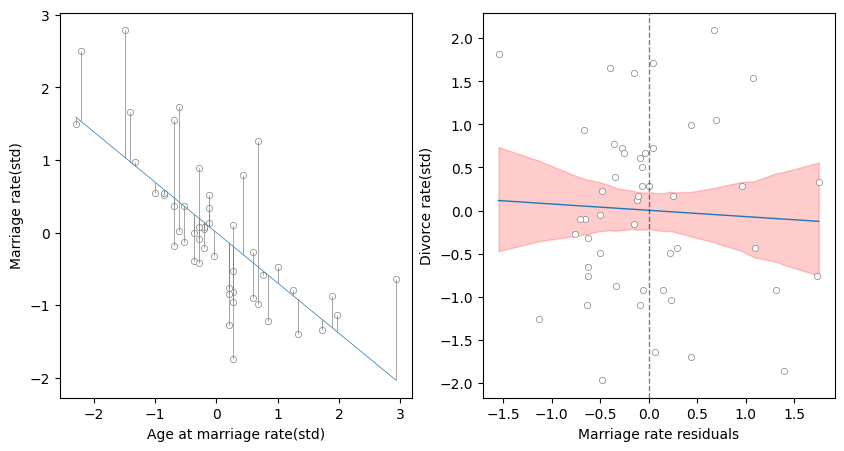

In [ ]:

sort_idx = np.argsort(d.A).values

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)

# plot age against marriage
plt.scatter(d.A, d.M, s=20 , facecolor='white', edgecolors='gray', linewidths=0.5, zorder=2)

# plot marriage residuals
plt.plot(d.A[sort_idx], mu_M.loc[sort_idx], linewidth=0.5)

# plot delta between marriage rate and marriage rate residuals
errors = np.vstack([mu_M.values, d.M.values])
errors.sort(axis=0)
plt.vlines(d.A, errors[0], errors[1], colors='gray', linewidths=0.5)

plt.xlabel('Age at marriage(std)')
plt.ylabel('Marriage rate(std)')

plt.subplot(1, 2, 2)

sort_idx = np.argsort(resid_M).values

mu_resid_M = trace5_13a.posterior.mu[0].mean(axis=0)
plt.scatter(resid_M, d.D, s=20 , facecolor='white', edgecolors='gray', linewidths=0.5, zorder=2)

plt.plot(resid_M[sort_idx], mu_resid_M[sort_idx], linewidth=1)

mu_resid_M_hdi = az.hdi(trace5_13a.posterior.mu).mu.values[sort_idx]
plt.axvline(0, linewidth=1, color='black', alpha=0.5, linestyle='dashed')
plt.fill_between(resid_M[sort_idx], mu_resid_M_hdi[:,0], mu_resid_M_hdi[:,1], color='red', alpha=0.2)
plt.xlabel('Marriage rate residuals')
plt.ylabel('Divorce rate(std)')



plt.show()
print(
"""
In the left plot, we plot the prediction line of age at marriage to the marriage rate, essentially using
one predictor to predict another. The 'error' between each data point and its mean line is the 'residual'.
When the residual is positive, it means that the observed rate was in excess of what the model expects.
Simply put, states with positive residuals have high marriage rates for their median age of marriage,
while states with negative residuals have low rates for their median age of marriage.

In the right plot, we take those residuals and use them to predict the divorce rate, the actual
outcome of interest. Since the line is relatively flat, we see that after 'controlling' for age, we no longer
see any relationship between marriage rate(residuals) and the divorce rate.
""")

In [ ]:
with pm.Model() as model5_13b:
    a = pm.Normal('a', mu=0, sigma=0.2)
    bM = pm.Normal('bM', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bM * d.M)
    A = pm.Normal('A', mu=mu, sigma=sigma, observed=d.A)
    trace5_13b = pm.sample()
    
mu_A = trace5_13b.posterior.mu[0].mean(axis=0)
resid_A = d.A - mu_A

with pm.Model() as model5_13c:
    a = pm.Normal('a', mu=0, sigma=0.2)
    brA = pm.Normal('brA', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + brA * resid_A)
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d.D)
    trace5_13c = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, brA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


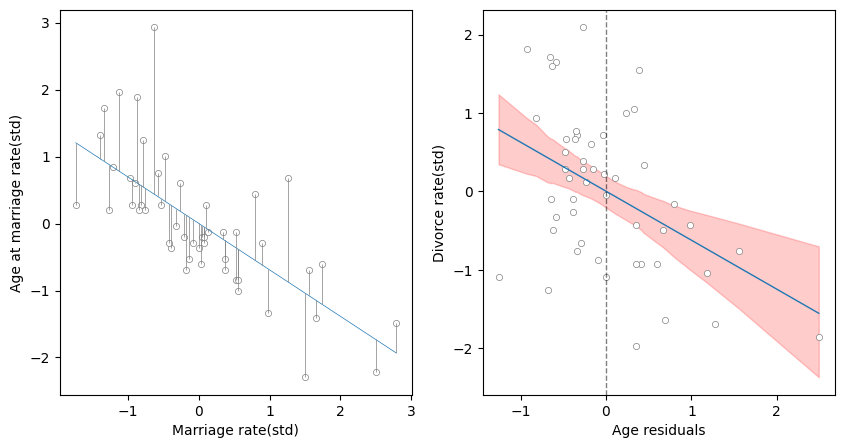

In [ ]:
sort_idx = np.argsort(d.M).values

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)

# plot marriage against age
plt.scatter(d.M, d.A, s=20 , facecolor='white', edgecolors='gray', linewidths=0.5, zorder=2)

# plot age residuals
plt.plot(d.M[sort_idx], mu_A.loc[sort_idx], linewidth=0.5)

# plot delta between age and age residuals
errors = np.vstack([mu_A.values, d.A.values])
errors.sort(axis=0)
plt.vlines(d.M, errors[0], errors[1], colors='gray', linewidths=0.5)

plt.xlabel('Marriage rate(std)')
plt.ylabel('Age at marriage rate(std)')


plt.subplot(1, 2, 2)

sort_idx = np.argsort(resid_A).values

mu_resid_A = trace5_13c.posterior.mu[0].mean(axis=0)
plt.scatter(resid_A, d.D, s=20 , facecolor='white', edgecolors='gray', linewidths=0.5, zorder=2)

plt.plot(resid_A[sort_idx], mu_resid_A[sort_idx], linewidth=1)

mu_resid_A_hdi = az.hdi(trace5_13c.posterior.mu).mu.values[sort_idx]
plt.axvline(0, linewidth=1, color='black', alpha=0.5, linestyle='dashed')
plt.fill_between(resid_A[sort_idx], mu_resid_A_hdi[:,0], mu_resid_A_hdi[:,1], color='red', alpha=0.2)
plt.xlabel('Age residuals')
plt.ylabel('Divorce rate(std)')



plt.show()

In [ ]:
# Code 5.19

with pm.Model() as model5_19:
    A = pm.MutableData('A', d.A, dims="obs_id")
    D_obs = pm.MutableData('D_obs', d.D, dims="obs_id")
    M_obs = pm.MutableData('M_obs', d.M, dims="obs_id")
    
    # A -> M
    aM = pm.Normal('aM', mu=0, sigma=0.2)
    bAM = pm.Normal('bAM', mu=0, sigma =0.5)
    sigmaM = pm.Exponential('sigmaM', 1)
    muM = pm.Deterministic('muM', aM + bAM * A, dims="obs_id")
    M = pm.Normal('M', mu=muM, sigma=sigmaM, observed=M_obs, dims="obs_id")
    
    
    # A -> D <- M
    a = pm.Normal('a', mu=0, sigma=0.2)
    bA = pm.Normal('bA', mu=0, sigma =0.5)
    bM = pm.Normal('bM', mu=0, sigma =0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bA * A + bM * M, dims="obs_id") # Note here we use M, not M_obs
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=D_obs, dims="obs_id")
    
    trace5_19 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigmaM, a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [ ]:
trace5_19_df = pm.to_inference_data(trace5_19).posterior.to_dataframe()
trace5_19_df.cov()

,aM,bAM,a,bA,bM,sigmaM,sigma,muM,mu
aM,0.008106,-0.000182,-0.000197,-0.000129,-0.000031,0.000103,0.000048,0.008106,-0.000197
bAM,-0.000182,0.010132,0.000050,0.000181,0.000115,0.000383,0.000138,-0.000182,0.000050
a,-0.000197,0.000050,0.010164,0.000193,0.000180,0.000230,0.000050,-0.000197,0.010164
bA,-0.000129,0.000181,0.000193,0.025024,0.017078,-0.000133,0.001081,-0.000129,0.000193
bM,-0.000031,0.000115,0.000180,0.017078,0.025291,-0.000026,0.000470,-0.000031,0.000180
sigmaM,0.000103,0.000383,0.000230,-0.000133,-0.000026,0.005529,-0.000081,0.000103,0.000230
sigma,0.000048,0.000138,0.000050,0.001081,0.000470,-0.000081,0.007800,0.000048,0.000050
muM,0.008106,-0.000182,-0.000197,-0.000129,-0.000031,0.000103,0.000048,0.486706,0.381516
mu,-0.000197,0.000050,0.010164,0.000193,0.000180,0.000230,0.000050,0.381516,0.347761


In [ ]:
seq = np.linspace(-2, 2, 40)
pm.set_data({"A": seq}, model=model5_19)
pred5_19 = pm.sample_posterior_predictive(trace5_19, model=model5_19, predictions=True)

Sampling: [D, M]


Text(0.5, 1.0, 'Counterfactual effect of A on M')

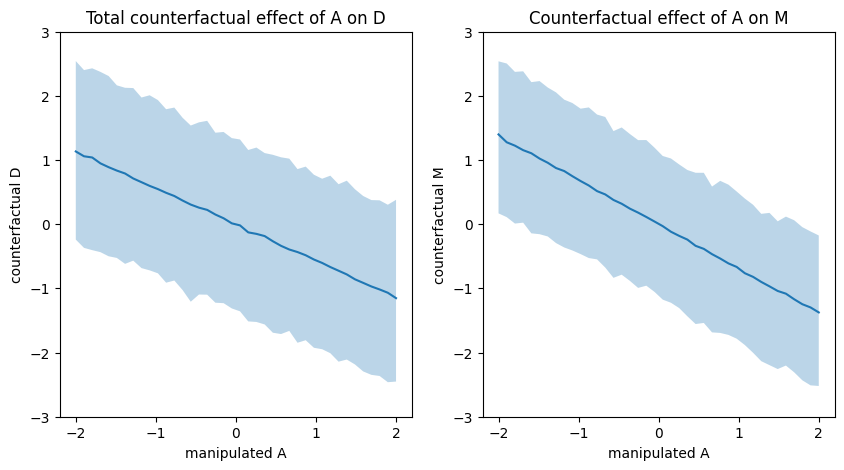

In [ ]:
# plot counterfactuals
preds = pred5_19.predictions.mean(dim=['chain', 'draw'])
preds_hdi = az.hdi(pred5_19, hdi_prob=0.89, group='predictions')

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(seq, preds.D)
plt.fill_between(seq, preds_hdi.D[:,0], preds_hdi.D[:,1], alpha=0.3)
plt.ylim([-3, 3])
plt.xlabel('manipulated A')
plt.ylabel('counterfactual D')
plt.title('Total counterfactual effect of A on D')



plt.subplot(1, 2, 2)
plt.plot(seq, preds.M)
plt.fill_between(seq, preds_hdi.M[:,0], preds_hdi.M[:,1], alpha=0.3)
plt.ylim([-3, 3])
plt.xlabel('manipulated A')
plt.ylabel('counterfactual M')
plt.title('Counterfactual effect of A on M')


In [ ]:
# trace5_19_cov = pm.to_inference_data(trace5_19).posterior.to_dataframe().cov()
# trace5_19_cov
d[['Marriage', 'MedianAgeMarriage']].cov()

,Marriage,MedianAgeMarriage
Marriage,14.424086,-3.405873
MedianAgeMarriage,-3.405873,1.546616


Notice how it M doesnt really have an effect on D when we hold A constant at the mean,
 and we vary M


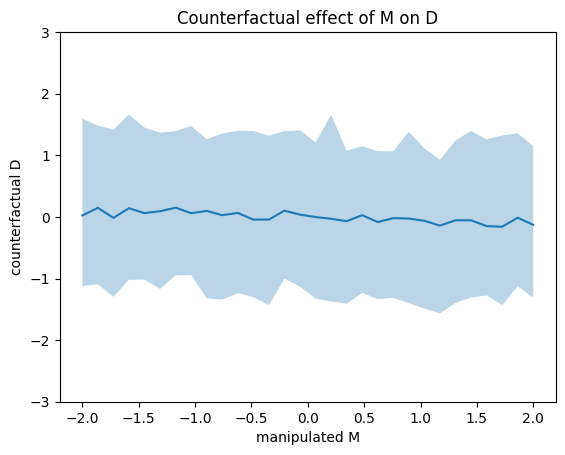

In [ ]:
# Plot another counterfactual. There doesnt seem to be a way in Pymc where I can hold a distribution constant
# for a counterfactual, so making another model.
M_seq = xa.DataArray(np.linspace(-2, 2, 30))
trace5_19_thinned = trace5_19.posterior.mean(dim=['chain']).sel(draw=slice(None, None, 5))
A = 0

mu_MD = trace5_19_thinned.a + trace5_19_thinned.bA * A + trace5_19_thinned.bM * M_seq

sigma = trace5_19_thinned.sigma.dot(xa.DataArray(np.ones(30)))

D = xa.DataArray(scp.stats.norm.rvs(loc=mu_MD,scale=sigma), dims=['draw', 'obs_id'])
D = D.expand_dims(dim={"chain": 1}) # must have chain, draw for az.hdi to be happy
D_hdi = az.hdi(D, hdi_prob=0.89)


plt.plot(M_seq, D.mean(dim=['chain', 'draw']))
plt.fill_between(M_seq, D_hdi.x[:,0], D_hdi.x[:,1], alpha=0.3)
plt.ylim([-3, 3])
plt.xlabel('manipulated M')
plt.ylabel('counterfactual D')
plt.title('Counterfactual effect of M on D')


print("Notice how it M doesnt really have an effect on D when we hold A constant at the mean,\n and we vary M")

# 5.2 Masked relationships

Masked relationships happen when there are 2 predictor variables that are correlated with one another, one being positively correlated with the outcome, and the other being negatively correlated with it.



In [ ]:
d = pd.read_csv('./data/milk.csv', sep=';')
d['K'] = scale_series(d['kcal.per.g'])
d['N'] = scale_series(d['neocortex.perc'])
d['M'] = scale_series(d['mass'])
d['lM'] = scale_series(np.log(d.mass))
dcc = d.dropna() # referred to in the book as 'Complete Case Analysis'
dcc.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M,lM
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812,-0.455836
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588,0.127441
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744,0.140751
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204,-0.307158
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082,-1.076270


In [ ]:
with pm.Model() as model5_29:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu=0, sigma=1)
    bN = pm.Normal('bN', mu=0, sigma =1)
    mu = pm.Deterministic('mu', a + bN * dcc.N)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K)

In [ ]:
def plot_priors_for_n_K(model):
    priorcheck = pm.sample_prior_predictive(samples=50, model=model)
    a = priorcheck.prior.a[0].values
    bN = priorcheck.prior.bN[0].values

    xs = np.linspace(-2, 2, 30)
    mu = a + bN * np.expand_dims(xs,0).T

    plt.plot(xs, mu, linewidth=0.5, c='tab:olive')
    plt.title(f'{model.a.str_repr()}, {model.bN.str_repr()}')
    plt.xlabel('neocortex percent(std)')
    plt.ylabel('kilocal per g(std)')
    plt.ylim(-2, 2) # limit to 2 std deviations
    plt.xlim(-2, 2) # limit to 2 std deviations
    plt.show()    

Sampling: [K, a, bN, sigma]


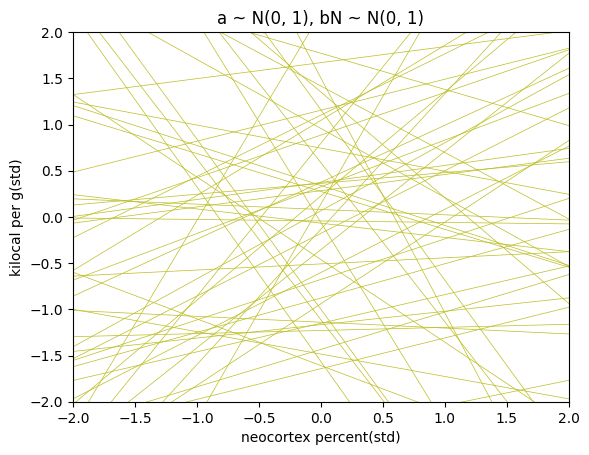

In [ ]:
plot_priors_for_n_K(model5_29)

Sampling: [K, a, bN, sigma]


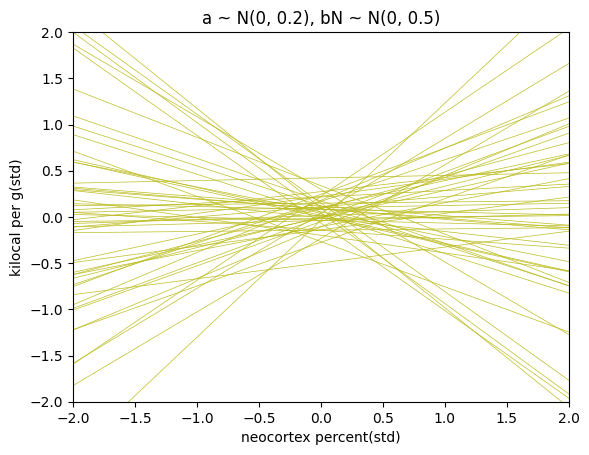

In [ ]:
with pm.Model() as model5_34:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu=0, sigma=0.2)
    bN = pm.Normal('bN', mu=0, sigma =0.5)
    N = pm.MutableData('N', dcc.N)
    mu = pm.Deterministic('mu', a + bN * N)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K)
    posterior5_34 = pm.sample()
plot_priors_for_n_K(model5_34)

This shows a weak positive relationship between neocortex percentage and milk energy


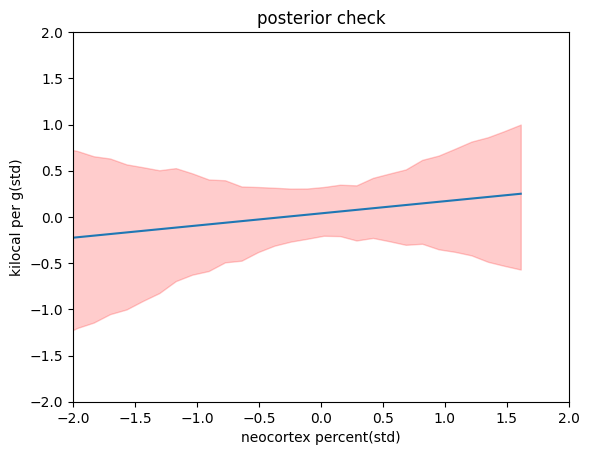

In [ ]:
def linear_model_posterior_check(*, a, beta, xs):
    mu = a + beta * np.expand_dims(xs,0).T
    mu_mean = mu.mean(axis=1)
    mu_hdi = np.array([az.hdi(m) for m in mu])

    plt.plot(xs, mu_mean)
    plt.fill_between(xs, mu_hdi[:, 0], mu_hdi[:, 1], color='red', alpha=0.2)
    plt.ylim(-2, 2) # limit to 2 std deviations
    plt.xlim(-2, 2) # limit to 2 std deviations


linear_model_posterior_check(a=posterior5_34.posterior.a[0].values,
                            beta=posterior5_34.posterior.bN[0].values,
                            xs=np.linspace(dcc.N.min()-0.15, dcc.N.max()+0.15, 30))
print('This shows a weak positive relationship between neocortex percentage and milk energy')
plt.xlabel('neocortex percent(std)')
plt.ylabel('kilocal per g(std)')
plt.title('posterior check')
plt.show()


In [ ]:
# Let's make a model that predics kilocals in milk from mass
# We take log mass because we think it is related to kilocals in milk by 'magnitude'

with pm.Model() as model5_37:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu=0, sigma=0.2)
    blM = pm.Normal('blM', mu=0, sigma =0.5)
    
    lM = pm.MutableData('lM', dcc.lM)
    mu = pm.Deterministic('mu', a + blM * lM)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K)
    posterior5_37 = pm.sample()


/var/folders/l3/jb3srxhd47x4q3y8b7vgxm8c0000gp/T/ipykernel_62234/692723038.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dcc.lM = scale_series(np.log(dcc.mass))
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, blM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Sampling: [K, a, blM, sigma]


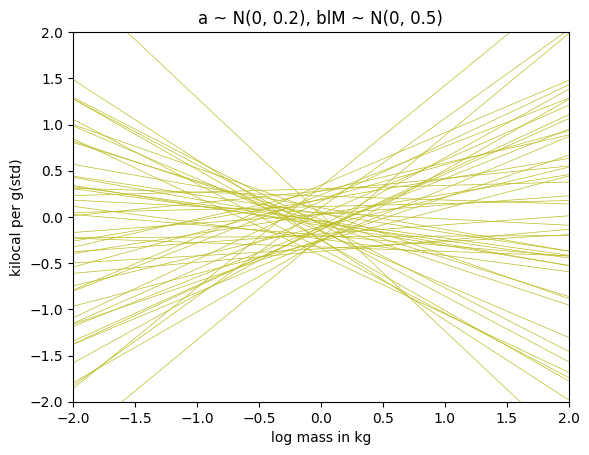

In [ ]:
def plot_priors_for_lM_K(model):
    priorcheck = pm.sample_prior_predictive(samples=50, model=model)
    a = priorcheck.prior.a[0].values
    blM = priorcheck.prior.blM[0].values

    xs = np.linspace(-2, 2, 30)
    mu = a + blM * np.expand_dims(xs,0).T

    plt.plot(xs, mu, linewidth=0.5, c='tab:olive')
    plt.title(f'{model.a.str_repr()}, {model.blM.str_repr()}')
    plt.xlabel('log mass in kg')
    plt.ylabel('kilocal per g(std)')
    plt.ylim(-2, 2) # limit to 2 std deviations
    plt.xlim(-2, 2) # limit to 2 std deviations
    plt.show()
    

plot_priors_for_lM_K(model5_37)

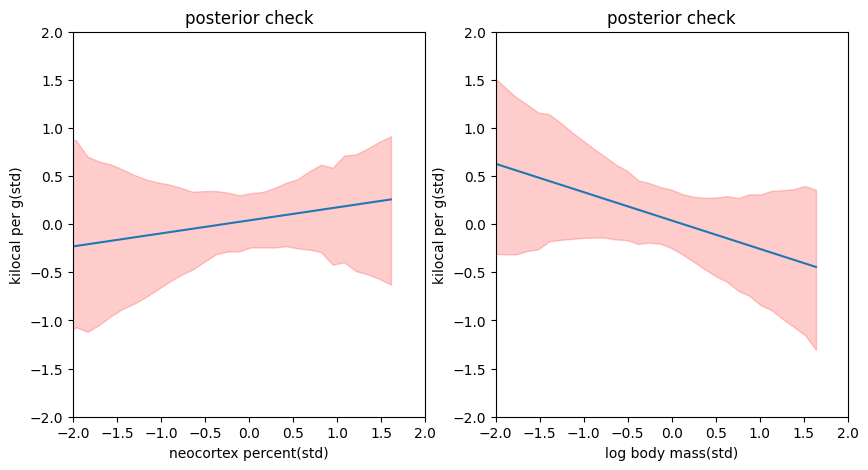

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
linear_model_posterior_check(a=posterior5_34.posterior.a[0].values,
                            beta=posterior5_34.posterior.bN[0].values,
                            xs=np.linspace(dcc.N.min()-0.15, dcc.N.max()+0.15, 30))
plt.xlabel('neocortex percent(std)')
plt.ylabel('kilocal per g(std)')
plt.title('posterior check')

plt.subplot(1, 2, 2)

linear_model_posterior_check(a=posterior5_37.posterior.a[0].values,
                            beta=posterior5_37.posterior.blM[0].values,
                            xs=np.linspace(dcc.lM.min()-0.15, dcc.lM.max()+0.15, 30))
plt.xlabel('log body mass(std)')
plt.ylabel('kilocal per g(std)')
plt.title('posterior check')
plt.show()

In [ ]:
# Now, let's try adding both parameters to the model

with pm.Model() as model5_38:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu=0, sigma=0.2)
    blM = pm.Normal('blM', mu=0, sigma =0.5)
    bN = pm.Normal('bN', mu=0, sigma =0.5)
    
    lM = pm.MutableData('lM', dcc.lM)
    N = pm.MutableData('N', dcc.N)
    mu = pm.Deterministic('mu', a + blM * lM + bN * N)
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=dcc.K)
    posterior5_38 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, blM, bN]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Notice that these slopes are more extreme than before - by plotting both parameters in the same model, we made their effect stronger - why?


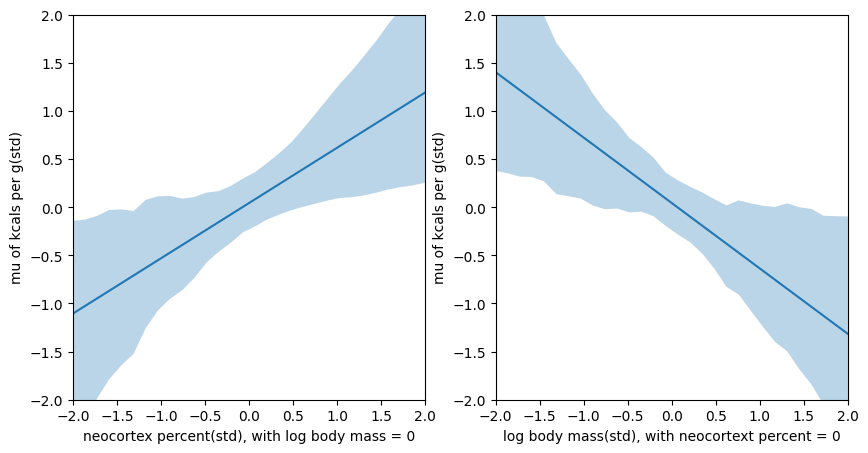

In [ ]:
# let's plot counter factuals
posterior5_38_thinned = posterior5_38.posterior.sel(draw=slice(None, None, 5)).stack(thinned=("chain", "draw"))

a = posterior5_38_thinned.a.values
blM = posterior5_38_thinned.blM.values
bN = posterior5_38_thinned.bN.values

lM_control = np.expand_dims(np.linspace(-2, 2, 30), 1)
N_control = np.expand_dims(np.linspace(-2, 2, 30), 1)
                            
mu_N = a + bN * N_control # lM is set to mean(0)
mu_lM = a + blM * lM_control # N is set to mean(0)

mu_N_mean = mu_N.mean(axis=1)
mu_lM_mean = mu_lM.mean(axis=1)

mu_N_hdi = np.array([az.hdi(m) for m in mu_N])
mu_lM_hdi = np.array([az.hdi(m) for m in mu_lM])


print("Notice that these slopes are more extreme than before - by plotting both parameters in the same model, \
we made their effect stronger - why?")
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(N_control, mu_N_mean)
plt.fill_between(N_control.reshape(-1), mu_N_hdi[:,0], mu_N_hdi[:,1], alpha=0.3)
plt.ylim(-2, 2) # limit to 2 std deviations
plt.xlim(-2, 2) # limit to 2 std deviations
plt.xlabel('neocortex percent(std), with log body mass = 0')
plt.ylabel('mu of kcals per g(std)')

plt.subplot(1, 2, 2)
plt.plot(lM_control, mu_lM_mean)
plt.fill_between(lM_control.reshape(-1), mu_lM_hdi[:,0], mu_lM_hdi[:,1], alpha=0.3)
plt.ylim(-2, 2) # limit to 2 std deviations
plt.xlim(-2, 2) # limit to 2 std deviations
plt.xlabel('log body mass(std), with neocortext percent = 0')
plt.ylabel('mu of kcals per g(std)')
plt.show()



What this shows is that both predictor variables are positively correlated with one another.



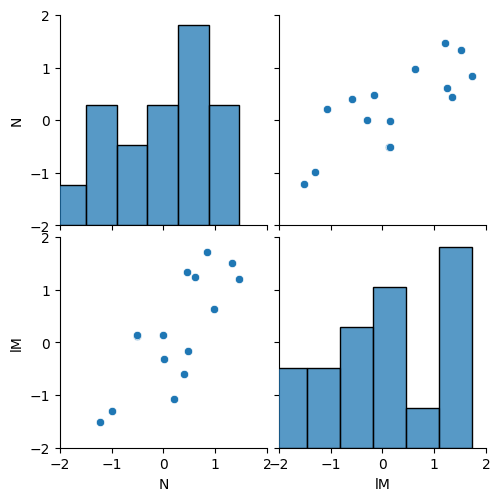

In [ ]:
from functools import reduce

pair_df = dcc[['N', 'lM']]

pairplot = sns.pairplot(pair_df)

# standardize axes
[ax.set_xlim(-2, 2) and ax.set_ylim(-2, 2) for arr in pairplot.axes for ax in arr]

print('''
What this shows is that both predictor variables are positively correlated with one another.
''')

This shows that one variable is positively correlated with the outcome, and the other is negatively correlated


/Users/yingquan.tan/.asdf/installs/python/3.10.7/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: The label '_nolegend_' of <matplotlib.patches.Patch object> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


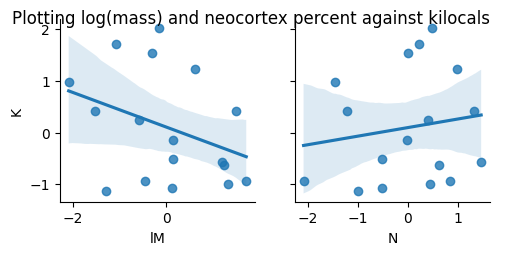

In [ ]:
x_vars = ["lM", "N"]
y_vars = ["K"]
g = sns.PairGrid(dcc, x_vars=x_vars, y_vars=y_vars)
g.map_offdiag(sns.regplot)
g.add_legend()
g.fig.suptitle('Plotting log(mass) and neocortex percent against kilocals')

print('This shows that one variable is positively correlated with the outcome, and the other is negatively correlated')

Here's another view of the above.Using boxplot, lazily, no easy way to plot floating bar with pre-set ticks. boxplot uses 50% quantile, plus some other nonsense. Point is, in the multiple regression case, the slopes of both lines become exaggerated, which is odd.


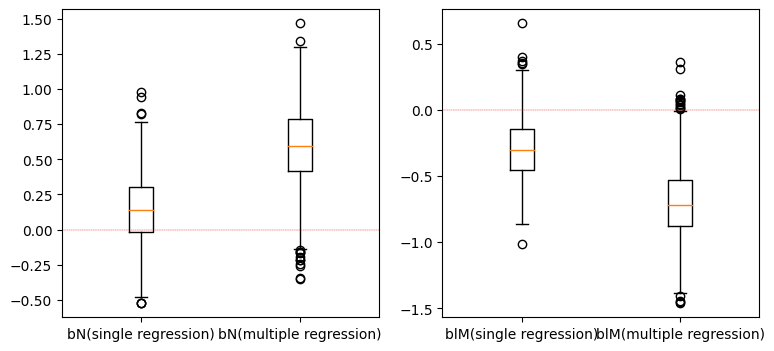

In [ ]:
print("Here's another view of the above.Using boxplot, lazily, no easy way to plot floating bar with \
pre-set ticks. boxplot uses 50% quantile, plus some other nonsense. Point is, in the multiple regression \
case, the slopes of both lines become exaggerated, which is odd.")
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax1.boxplot([posterior5_34.posterior.bN[0].values,posterior5_38_thinned.bN.values],
           labels=['bN(single regression)', 'bN(multiple regression)'])
ax1.axhline(y=0, color = 'r', linestyle = '--', linewidth=0.3)


ax2.boxplot([posterior5_37.posterior.blM[0].values,posterior5_38_thinned.blM.values],
                       labels=['blM(single regression)', 'blM(multiple regression)'])
ax2.axhline(y=0, color = 'r', linestyle = '--', linewidth=0.3)


plt.show()



In [ ]:
posterior5_34.posterior.bN[0].values


array([ 0.17107471, -0.28407325,  0.02700621,  0.08541196,  0.29813362,
        0.18710183, -0.3915531 ,  0.34439666,  0.28507314,  0.00102096,
        0.22776526,  0.00454652,  0.2564093 , -0.01458814,  0.15439216,
       -0.02558152, -0.02558152, -0.04791463,  0.2687186 ,  0.34008801,
        0.10953168,  0.13915017,  0.13915017,  0.16565831,  0.54694713,
        0.00274502,  0.19834829, -0.06649314,  0.35298806, -0.08034829,
        0.00112637,  0.20396757, -0.23942842, -0.16075578,  0.50168712,
        0.02599714,  0.26376472,  0.04284433,  0.32502054,  0.3333897 ,
       -0.31721685,  0.32534485, -0.01952764,  0.33040614, -0.13005518,
        0.1895044 ,  0.53296957,  0.22998783, -0.07650701,  0.21172271,
        0.29247902,  0.03794273, -0.08288887,  0.21812783,  0.16858941,
        0.06642874, -0.0665391 ,  0.42622029, -0.17519612, -0.01306459,
        0.20390369,  0.49672741,  0.49672741, -0.14853589,  0.29486276,
       -0.03980545,  0.32586255,  0.30131282, -0.14503211,  0.38

In [ ]:
N_control.reshape(-1)

array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
       -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
       -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
        0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
        0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
        1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ])

In [ ]:
# Test for categorical variables - create two distinct, known distributions and assign them to categories.
vals = np.concatenate([scp.stats.norm.rvs(loc=0.3, scale=0.1, size=100), 
                       scp.stats.norm.rvs(loc=0.2, scale=0.02, size=100),
                       scp.stats.norm.rvs(loc=0.4, scale=0.03, size=100)])
idxs = np.concatenate([np.zeros(100, dtype=int), np.ones(100, dtype=int), np.ones(100, dtype=int) * 2])
catdata = pd.DataFrame({ "val": vals, "cat": idxs })
size = catdata.cat.unique().size
with pm.Model() as catmodel:
    sigma = pm.Uniform('sigma', 0, 0.5, shape=size)
    mu = pm.Normal('mu', mu=0.3, sigma=sigma, shape=size) 
    val = pm.Normal('val', mu=mu[catdata.cat.values], sigma=sigma[catdata.cat.values], observed=catdata.val)
    catposterior = pm.sample()




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Sampling: [val]


(0.0, 1.0)

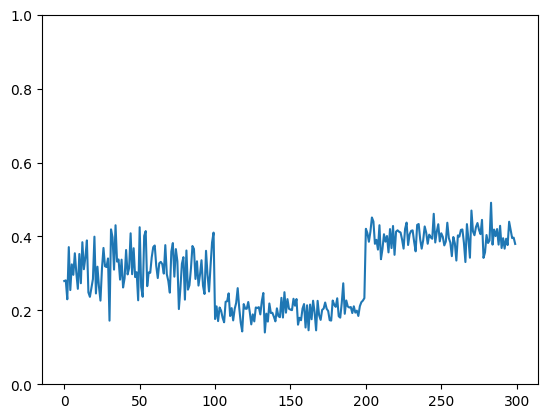

In [ ]:
# This shows that by manipulating the shape of the vars, we can train for multiple categories
# simultaneously
catsample = pm.sample_posterior_predictive(catposterior, model=catmodel)
plt.plot(catsample.posterior_predictive.val[1][100])
plt.ylim(0, 1)


In [ ]:
# So now, armed with this, lets try the categorical example from the book:
d = pd.read_csv('./data/milk.csv', sep=';', dtype= {'clade': 'category'})

d['K'] = scale_series(d['kcal.per.g'])

print(d.clade.cat.categories)
print(f'num of categories {len(d.clade.cat.categories)}')
# d['N'] = scale_series(d['neocortex.perc'])
# d['M'] = scale_series(d['mass'])
# dcc = d.dropna() # referred to in the book as 'Complete Case Analysis'
# dcc.head()

Index(['Ape', 'New World Monkey', 'Old World Monkey', 'Strepsirrhine'], dtype='object')
num of categories 4


In [ ]:
# Now lets build the model:
with pm.Model() as model_5_51:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', mu=0, sigma=0.5, shape=len(d.clade.cat.categories))
    mu = pm.Deterministic('mu', a[d.clade.cat.codes])
    K = pm.Normal('K', mu=mu, sigma=sigma, observed=d.K)
    posterior_5_51 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [ ]:
clade_mapping = dict(zip(range(0, len(d.clade.cat.categories)), d.clade.cat.categories))
clade_mapping

{0: 'Ape', 1: 'New World Monkey', 2: 'Old World Monkey', 3: 'Strepsirrhine'}

Text(0.5, 0, 'expected kcal(std)')

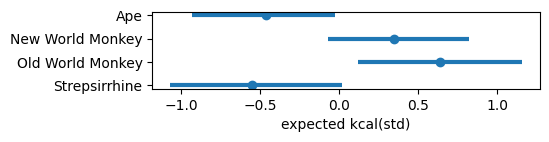

In [ ]:
# a_per_clade = posterior_5_51.posterior.a.stack(x=['chain', 'draw'])
# a_per_clade = a_per_clade.rename('a_per_clade')
# a_per_clade = a_per_clade.rename(a_dim_0='clade')
# a_per_clade = a_per_clade.rename(clade=list(d.clade.cat.categories))

plt.figure(figsize=(5, 1))
posterior = posterior_5_51.posterior
posterior = posterior.rename_dims(a_dim_0='clade')
posterior.coords['clade'] = d.clade.cat.categories
posterior = posterior.stack(x=['chain', 'draw'])
a_mean = posterior.a.mean(dim='x')
hdi = az.hdi(posterior_5_51.posterior, var_names=['a'])

# This contortion needs to happen as errorbar expects positive -/+ values from the 
# 'x' positions.
hdi_vals = hdi.a.values
hdi_vals = np.abs(hdi_vals - np.expand_dims(a_mean.values, 1)).T

y_points = np.linspace(0, -1, 4) # Do this so that that index 0 is on the top, and 3 is on the bottom
plt.errorbar(a_mean, y_points , xerr=hdi_vals, fmt='C0o',lw=3)
plt.yticks(y_points, d.clade.cat.categories);

plt.xlabel('expected kcal(std)')

# Practice


5E1: (2), (4)
5E2: animal_diversity_mu = alpha + latitude_slope * latitude + plant_diversity_slope * plant_diversity
5E3: time_to_degree_mu = alpha + funding_slope * funding + size_slope * size. Each slope should be positive.

These two variables might be positively associated with the outcome, but negatively associated with another. For example, large labs have less funding per student. Small labs have more funding per student, but poorer intellectual environments.

5M1: Have a model like B -> C, A -> C A is positively correlated with B, which is positively correlated with C(outcome variable). Regressing with both A and B in the model should diminish the effect of B. For example: predict the likelihood of bike accidents in the city, given the (A) the number of bikers in the city and (B) the proportion of roads that have bike lanes. A is positively correlated with B, and is trivially positively correlated with C, making it seem like B -> C.

5M2: Have a model like A -> C <- B, A -> B, where A positively associated with C, and B is negatively associatied with C. A is then positively associated with B. In the bike accident case, perhaps A) number of cars. and B) proportion of roads with bike bike lanes.
Higher number of cars causes more accidents, and more bike lanes means less accidents, but cities with more cars have less bike lanes.


5M3: A high divorce rate may normalize divorces, making it less taboo, and thereby making marriages less of something seen as a thing that should happen once(or infrequently). To test this, some classification of first marriage vs remarriage rate is needed. In emprical contexts, causation involves feedback loops that can render regression useless without a time series framework.